# Adding your own models:

This notebook is intended for presenting the general workflow of adding further models.

In theory, the framwork allows for training of any parameterized model on the data set, as long as its function call is differentiable w.r.t. to its parameters (once more a lot of heavy lifting is done by the equinox python package (https://docs.kidger.site/equinox/).

**However**: Everything that is defined as a `jax.Array` will be interpreted as a trainable parameter! For instance, one could define the normalization values as a `jax.Array`. These will then also be trained. If intentional it might be okay, but it can also lead to some confusing bugs..

The model needs to provide an API as specified in `rhmag/model_interfaces/model_interface.py`.
The necessary functions are `__call__` and `normalized_call`.

In [1]:
# optional setup
%load_ext autoreload
%autoreload 2

import traceback
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'  # choose cuda-device
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"  # disable preallocation of memory


import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
jax.config.update("jax_platform_name", "cpu")  # optionally run on cpu

In [2]:
from rhmag.model_interfaces.model_interface import ModelInterface

In [3]:
ModelInterface.__call__

<function rhmag.model_interfaces.model_interface.ModelInterface.__call__(self, B_past: jax.jaxlib._jax.Array, H_past: jax.jaxlib._jax.Array, B_future: jax.jaxlib._jax.Array, T: jax.jaxlib._jax.Array) -> jax.jaxlib._jax.Array>

In [4]:
ModelInterface.normalized_call

<function rhmag.model_interfaces.model_interface.ModelInterface.normalized_call(self, B_past_norm: jax.jaxlib._jax.Array, H_past_norm: jax.jaxlib._jax.Array, B_future_norm: jax.jaxlib._jax.Array, T_norm: jax.jaxlib._jax.Array) -> jax.jaxlib._jax.Array>

You cannot instantiate the default class because it is abstract and you need to inherit from it first:

In [5]:
try:
    ModelInterface()
except TypeError:
    traceback.print_exc()

Traceback (most recent call last):
  File "/tmp/ipykernel_445834/1470132836.py", line 2, in <module>
    ModelInterface()
  File "/home/hvater/venvs/rhino-mag/lib/python3.11/site-packages/equinox/_module/_module.py", line 396, in __call__
    self = tryself = super().__call__(*args, **kwargs)  # pyright: ignore[reportAttributeAccessIssue]
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/hvater/venvs/rhino-mag/lib/python3.11/site-packages/equinox/_module/_better_abstract.py", line 233, in __call__
    self = super().__call__(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/hvater/venvs/rhino-mag/lib/python3.11/site-packages/equinox/_module/_module.py", line 542, in __new__
    self = super().__new__(cls)
           ^^^^^^^^^^^^^^^^^^^^
TypeError: Can't instantiate abstract class ModelInterface with abstract methods __call__, normalized_call


This is a very, very simple model with one trainable parameter. It simply always predicts a constant value.
Training it would yield the best constant value to approximate the training data set (likely close to the mean of the data, depending on the exact shape of the training loss):

The model:
```
from typing import Callable

import jax
import jax.numpy as jnp
import equinox as eqx


class DummyModel(eqx.Module):
    theta: jax.Array

    def __init__(self, key: jax.random.PRNGKey):
        self.theta = jax.random.normal(key, shape=())

    def __call__(self, x):
        return self.theta * jnp.ones(x.shape)

```

And model interface:
```
from typing import Callable

import jax
import jax.numpy as jnp
import equinox as eqx

from rhmag.data_management import Normalizer
from rhmag.model_interfaces.model_interface import ModelInterface
from rhmag.models.dummy_model import DummyModel

class DummyModelInterface(ModelInterface):
    model: DummyModel
    normalizer: Normalizer
    featurize: Callable = eqx.field(static=True)

    def __call__(
        self,
        B_past: jax.Array,
        H_past: jax.Array,
        B_future: jax.Array,
        T: jax.Array,
    ) -> jax.Array:

        # concatenating and normalizing the data
        B_all = jnp.concatenate([B_past, B_future], axis=1)
        B_all_norm, H_past_norm, T_norm = self.normalizer.normalize(B_all, H_past, T)

        B_past_norm = B_all_norm[:, : B_past.shape[1]]
        B_future_norm = B_all_norm[:, B_past.shape[1] :]

        # performing prediction
        batch_H_pred = self.normalized_call(B_past_norm, H_past_norm, B_future_norm, T_norm)

        # denormalizing predicted value
        batch_H_pred_denorm = jax.vmap(jax.vmap(self.normalizer.denormalize_H))(batch_H_pred)

        return batch_H_pred_denorm

    def normalized_call(
        self,
        B_past_norm: jax.Array,
        H_past_norm: jax.Array,
        B_future_norm: jax.Array,
        T_norm: jax.Array,
        warmup: bool = True,
    ) -> jax.Array:
        batch_H_pred = jax.vmap(self.model)(B_future_norm)
        return batch_H_pred
```

To be able to use this model, you would need to make it importable from within the package. That is, it would need to be added to a python file within the source code.

Additionally, the model needs to be added as an option to the `setup_model`-function, so that it may be chosen as a `model_type` in the training script.
The function can be found in `rhmag/model_setup.py`.

An entry like:
```
case "DummyModel":
    model_params_d = dict(key=model_key)
    model = DummyModel(key=model_key)
    mdl_interface_cls = DummyModelInterface
```
needs to be added.

For this specific example, this all has been done. 
You can find the `DummyModel` at `rhmag/models/dummy_model.py`, the `DummyModelInterface` at `rhmag/model_interfaces/dummy_model_interface.py`, and the added case for the `DummyModel` in `rhmag/model_setup.py`.


As a result, we can create such a model using the `setup_model` function:

In [6]:
from rhmag.model_setup import setup_model, setup_featurize
from rhmag.data_management import Normalizer

INFO:2026-01-27 17:56:51,686:jax._src.xla_bridge:834: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


2026-01-27 17:56:51 | INFO : Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


In [7]:
identity_function = lambda x : x  # just returns its input, i.e., no featurization
normalizer = Normalizer(B_max=1.0, H_max=1.0, T_max=1.0, norm_fe_max=[], H_transform=identity_function, H_inverse_transform=identity_function)  # placeholder normalizer that does nothing
model, model_parameter_dict = setup_model(
    model_label="DummyModel",
    model_key=jax.random.PRNGKey(0),
    normalizer=normalizer,
    featurize=setup_featurize("reduce", 0, 0)
)
display("model parameters:", model_parameter_dict)
print()
display("model:", model)

'model parameters:'

{'key': Array([0, 0], dtype=uint32)}

'model:'

DummyModelInterface(
  model=DummyModel(theta=f32[]),
  normalizer=Normalizer(
    B_max=1.0,
    H_max=1.0,
    T_max=1.0,
    norm_fe_max=[],
    H_transform=<function <lambda>>,
    H_inverse_transform=<function <lambda>>
  ),
  featurize=partial(<function setup_featurize.<locals>.featurize>, time_shift=0)
)

And we can also train versions of it using the main training function:

In [8]:
from rhmag.runners.rnn_training_jax import train_model_jax

In [9]:
train_model_jax(
    material_name="B",
    model_types=["DummyModel"],
    seeds=[155],
    epochs=1000,
    loss_type="MSE",
    disable_f64=True,
)

2026-01-27 17:56:52 | INFO : Starting experiments for 1 model type(s) and 1 seeds: ['DummyModel'], [155]
2026-01-27 17:56:52 | INFO : --- Starting experiments for Model Type: DummyModel ---


Loading data for B:  10%|███████████████████████▌                                                                                                                                                                                                                                | 2/21 [00:01<00:15,  1.22it/s]

Loaded DataFrame at /home/hvater/projects/RHINO-MAG/data/cache/B_2_B.parquet is empty.
Loaded DataFrame at /home/hvater/projects/RHINO-MAG/data/cache/B_2_H.parquet is empty.
Loaded DataFrame at /home/hvater/projects/RHINO-MAG/data/cache/B_2_T.parquet is empty.


Loading data for B: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:03<00:00,  6.74it/s]


Loaded DataFrame at /home/hvater/projects/RHINO-MAG/data/cache/B_6_B.parquet is empty.
Loaded DataFrame at /home/hvater/projects/RHINO-MAG/data/cache/B_6_H.parquet is empty.
Loaded DataFrame at /home/hvater/projects/RHINO-MAG/data/cache/B_6_T.parquet is empty.
Given DataFrames for B, H, and T at frequency 80000.0 are empty. Skipping this frequency for the given material.
Given DataFrames for B, H, and T at frequency 500000.0 are empty. Skipping this frequency for the given material.
2026-01-27 17:57:04 | INFO : Training starting. Experiment ID is 'B_DummyModel_d943c400_seed155'.
2026-01-27 17:57:04 | INFO : train size: 4654, val size: 1009, test size: 1006
2026-01-27 17:57:05 | INFO : Test loss seed 155: 609.427490 A/m


Seed 155: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:54<00:00, 18.19epoch/s, Loss 5.67e-03| val loss 1.00e+00]

2026-01-27 17:58:00 | INFO : Test loss seed 155: 0.999947 A/m
2026-01-27 17:58:00 | INFO : Training done. Proceeding with evaluation..


2026-01-27 17:58:20 | INFO : Evaluation done. Proceeding with storing experiment data..
DummyModelInterface(
  model=DummyModel(theta=f32[]),
  normalizer=Normalizer(
    B_max=0.5342190265655518,
    H_max=295.66217041015625,
    T_max=70,
    norm_fe_max=[
      0.9934781789779663, 0.01088009774684906, 0.004742095246911049, 1.0
    ],
    H_transform=<function FrequencySet.normalize.<locals>.<lambda>>,
    H_inverse_transform=<function FrequencySet.normalize.<locals>.<lambda>>
  ),
  featurize=partial(<function setup_featurize.<locals>.featurize>, time_shift=0)
)
2026-01-27 17:58:26 | INFO : Experiment with id 'B_DummyModel_d943c400_seed155' finished successfully. Parameters, logs, evaluation metrics, and the model have been stored successfully.
2026-01-27 17:58:28 | INFO : All scheduled experiments completed.


Checking its performance:

In [10]:
from rhmag.utils.model_evaluation import reconstruct_model_from_file, get_exp_ids
from rhmag.utils.model_evaluation import plot_model_frequency_sweep, plot_first_predictions

In [11]:
dummy_model_exp_ids = get_exp_ids(material_name="B", model_type="DummyModel")
dummy_model_exp_ids

['B_DummyModel_c48e643b_seed155',
 'B_DummyModel_4d03c358_seed155',
 'B_DummyModel_d943c400_seed155']

In [12]:
exp_id = dummy_model_exp_ids[-1] # or choose whichever model you want to test..
model = reconstruct_model_from_file(exp_id) 

Found model file at '/home/hvater/projects/RHINO-MAG/data/models/B_DummyModel_d943c400_seed155.eqx'. Loading model..


In [13]:
from rhmag.utils.model_evaluation import (
    load_gt_and_pred, plot_worst_predictions, plot_first_predictions, plot_loss_trends
)

In [14]:
seed=exp_id.split("seed")[-1]
gt, pred = load_gt_and_pred(
    exp_id=exp_id,
    seed=seed,
    freq_idx=0
)

MAE 23.2 A/m | MSE 1018.8 (A/m)² | RMSE 1.000


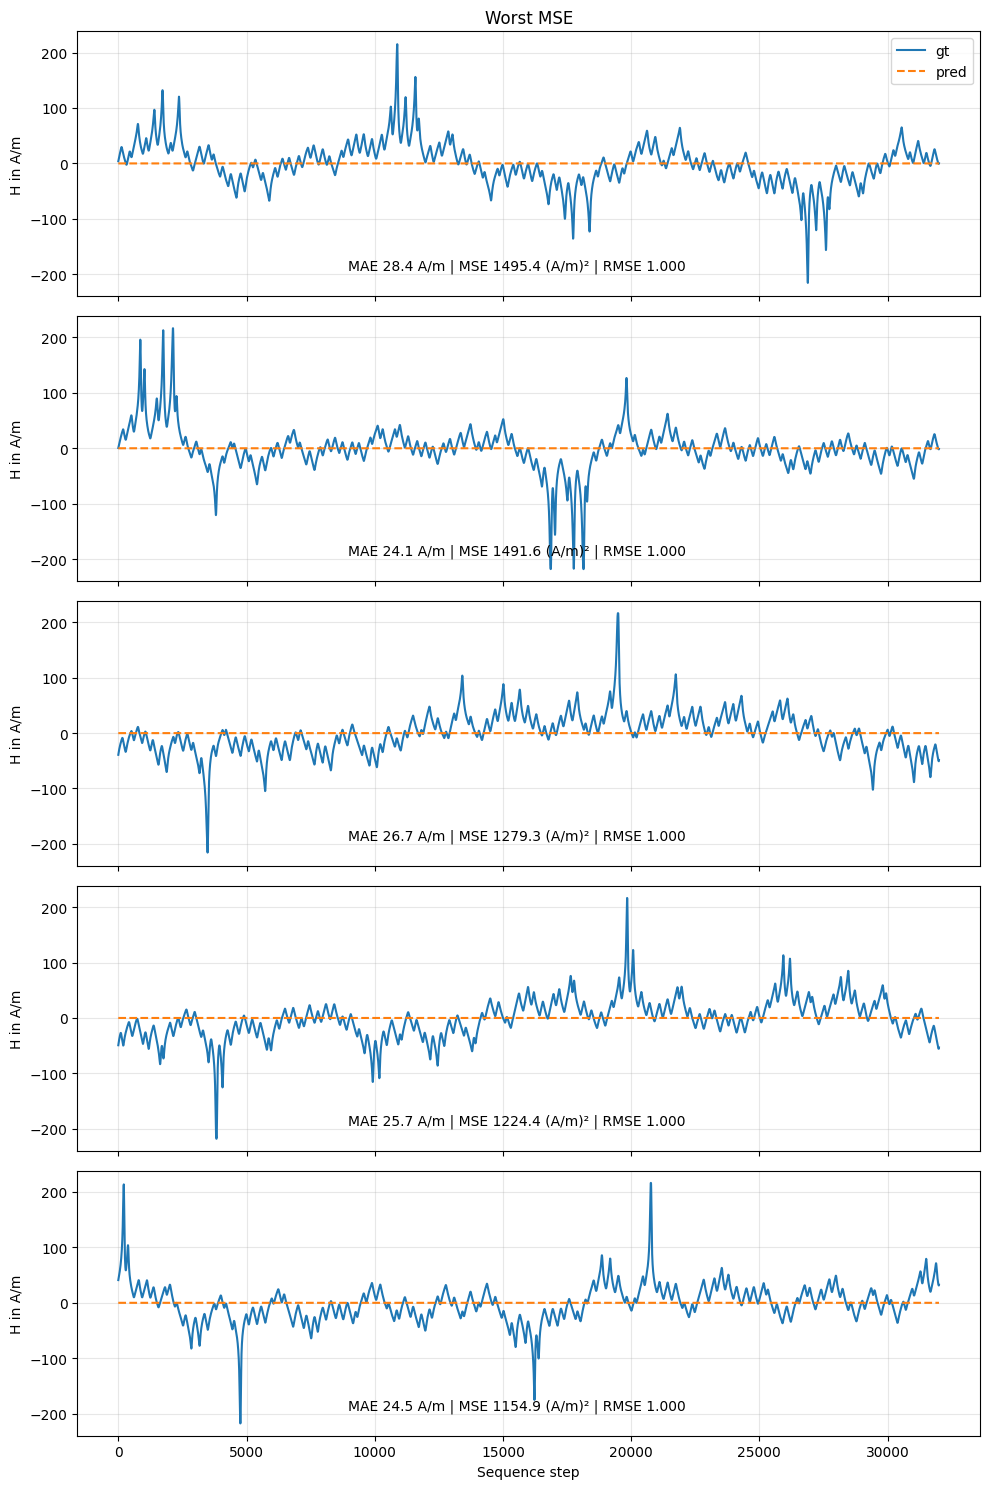

MAE 23.2 A/m | MSE 1018.8 (A/m)²


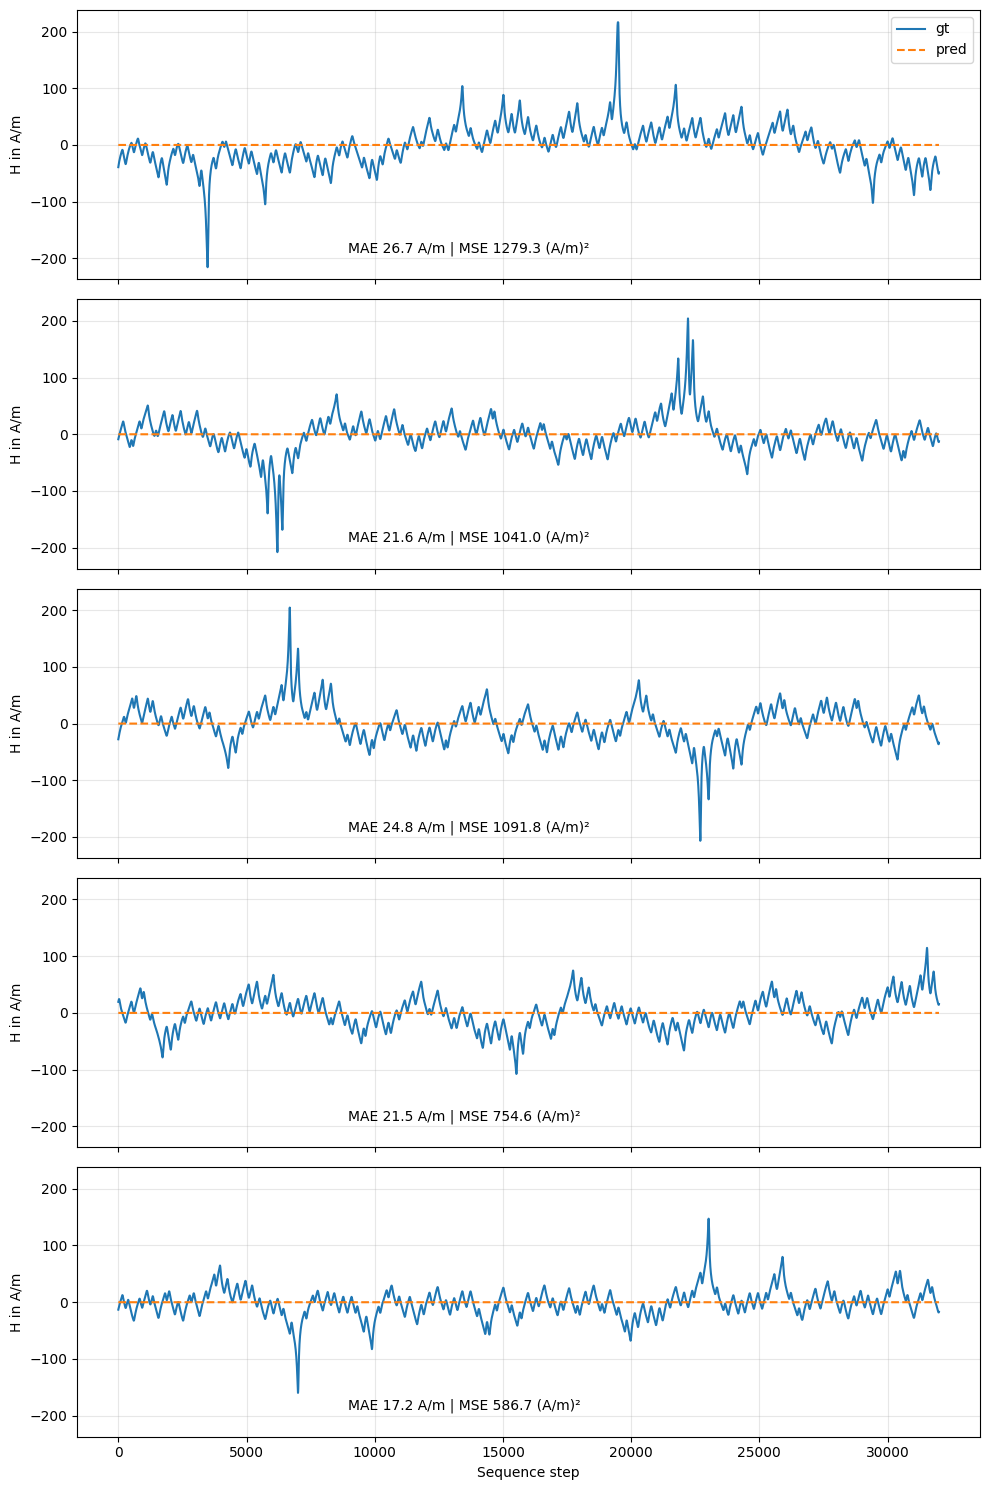

2026-01-27 17:58:30 | INFO : Substituting symbol L from STIXNonUnicode
2026-01-27 17:58:30 | INFO : Substituting symbol L from STIXNonUnicode


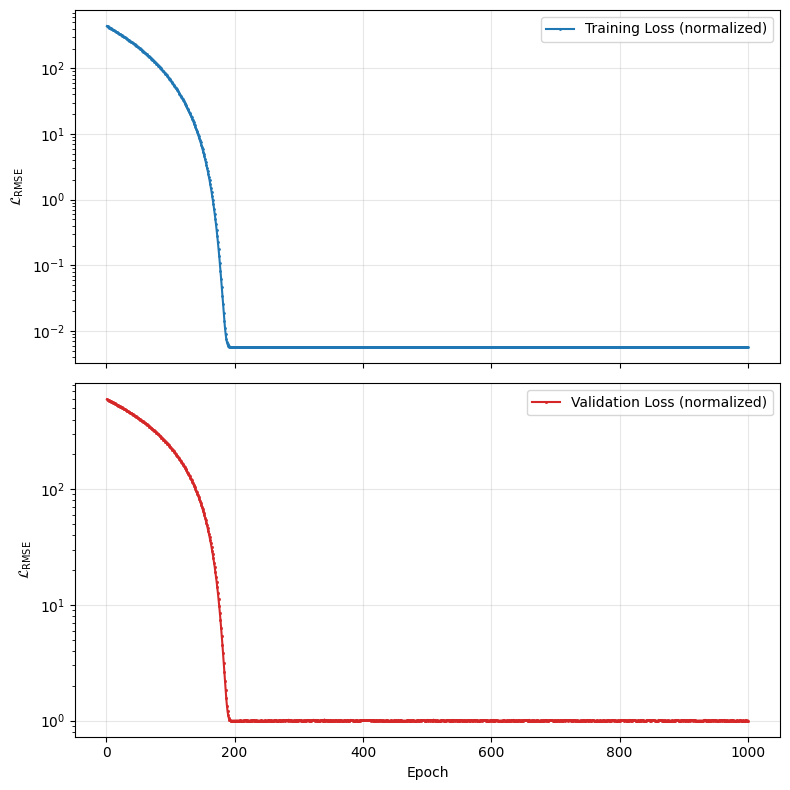

In [15]:
plot_worst_predictions(gt, pred);
plt.show()

plot_first_predictions(gt, pred);
plt.show()

plot_loss_trends(exp_id, seed);
plt.show()

In [16]:
from rhmag.data_management import DataSet, MaterialSet

In [17]:
material_set = MaterialSet.from_material_name("B")
train_set, eval_set, test_set = material_set.split_into_train_val_test()

Loading data for B:  10%|███████████████████████▌                                                                                                                                                                                                                                | 2/21 [00:01<00:14,  1.27it/s]

Loaded DataFrame at /home/hvater/projects/RHINO-MAG/data/cache/B_2_B.parquet is empty.
Loaded DataFrame at /home/hvater/projects/RHINO-MAG/data/cache/B_2_H.parquet is empty.
Loaded DataFrame at /home/hvater/projects/RHINO-MAG/data/cache/B_2_T.parquet is empty.


Loading data for B: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:03<00:00,  6.98it/s]


Loaded DataFrame at /home/hvater/projects/RHINO-MAG/data/cache/B_6_B.parquet is empty.
Loaded DataFrame at /home/hvater/projects/RHINO-MAG/data/cache/B_6_H.parquet is empty.
Loaded DataFrame at /home/hvater/projects/RHINO-MAG/data/cache/B_6_T.parquet is empty.
Given DataFrames for B, H, and T at frequency 80000.0 are empty. Skipping this frequency for the given material.
Given DataFrames for B, H, and T at frequency 500000.0 are empty. Skipping this frequency for the given material.


(<Figure size 3000x800 with 21 Axes>,
 array([[<Axes: title={'center': 'frequency: 50 kHz'}, xlabel='k', ylabel='B'>,
         <Axes: title={'center': 'frequency: 125 kHz'}, xlabel='k', ylabel='B'>,
         <Axes: title={'center': 'frequency: 200 kHz'}, xlabel='k', ylabel='B'>,
         <Axes: title={'center': 'frequency: 320 kHz'}, xlabel='k', ylabel='B'>,
         <Axes: title={'center': 'frequency: 800 kHz'}, xlabel='k', ylabel='B'>,
         <Axes: >, <Axes: >],
        [<Axes: xlabel='k', ylabel='H'>, <Axes: xlabel='k', ylabel='H'>,
         <Axes: xlabel='k', ylabel='H'>, <Axes: xlabel='k', ylabel='H'>,
         <Axes: xlabel='k', ylabel='H'>, <Axes: >, <Axes: >],
        [<Axes: xlabel='H', ylabel='B'>, <Axes: xlabel='H', ylabel='B'>,
         <Axes: xlabel='H', ylabel='B'>, <Axes: xlabel='H', ylabel='B'>,
         <Axes: xlabel='H', ylabel='B'>, <Axes: >, <Axes: >]], dtype=object))

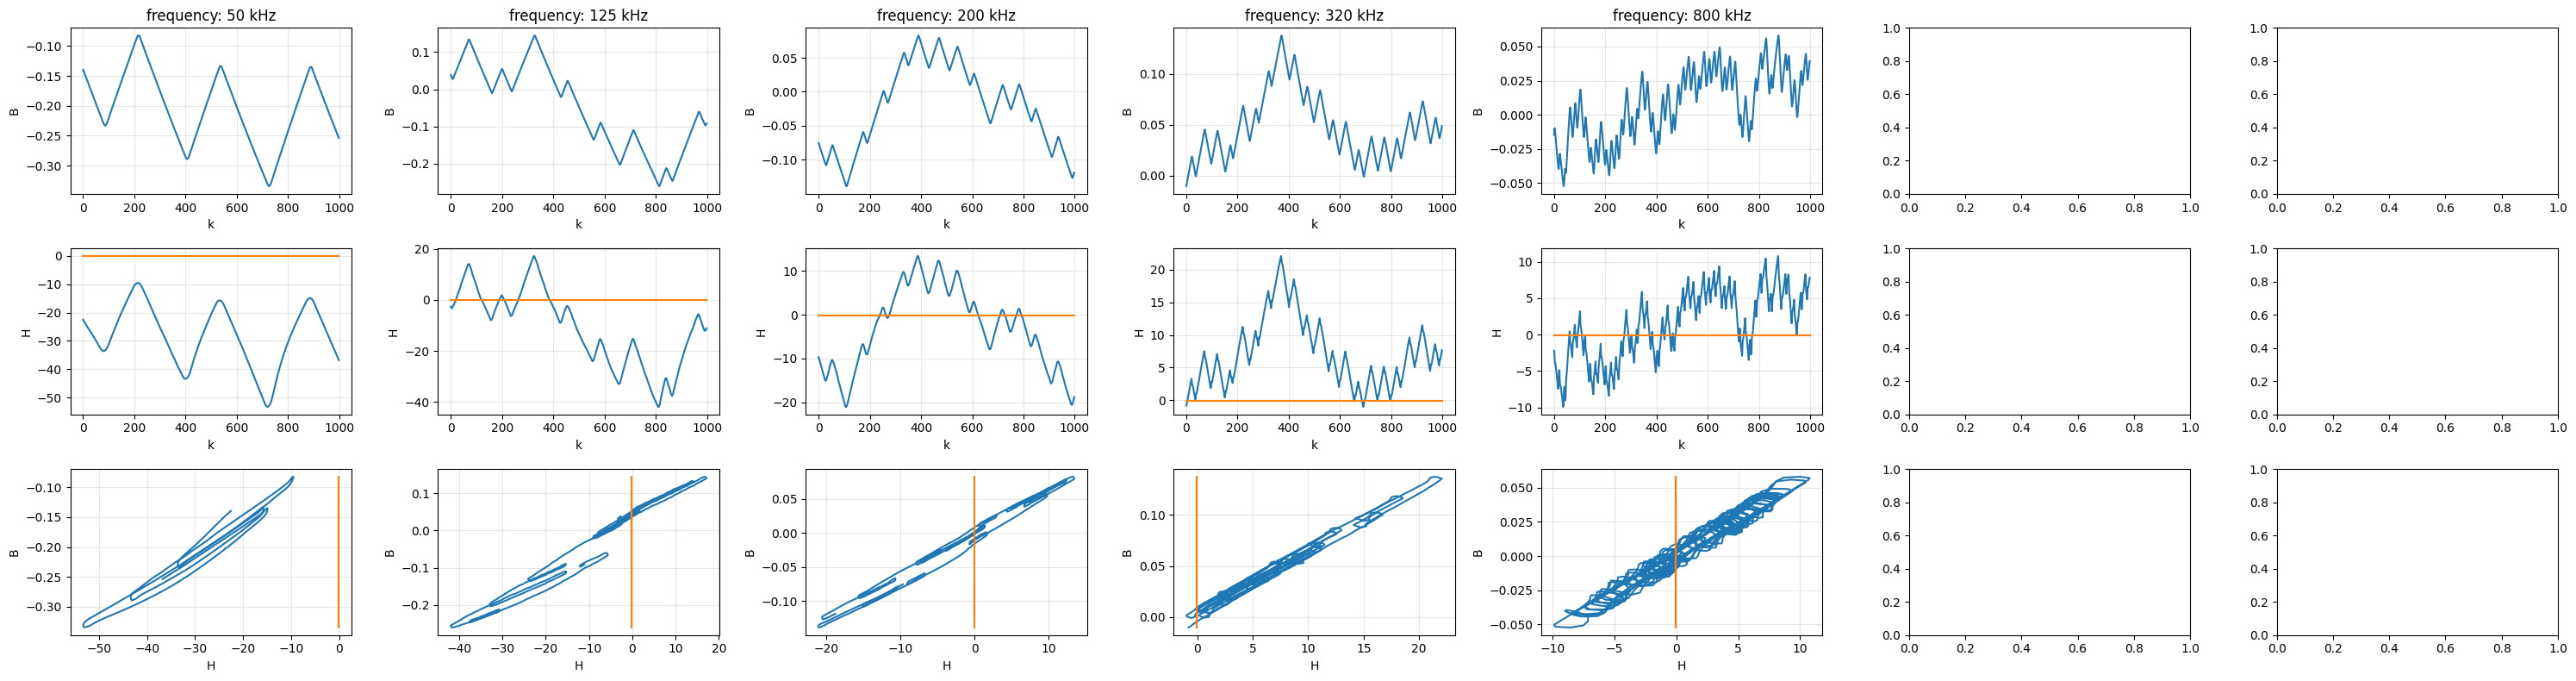

In [18]:
plot_model_frequency_sweep(model, test_set, loader_key=jax.random.PRNGKey(21), past_size=1)

sanity checking model output:

In [19]:
print("model_output:", model.normalizer.denormalize_H(model.model.theta))

model_output: -0.08519489


In [20]:
average_field = []
for frequency_set in train_set:
    average_field.append(jnp.mean(frequency_set.H))
average_H = jnp.mean(jnp.array(average_field))
print("average field value for the data set:", average_H)

average field value for the data set: -0.5660259


The model outputs roughly $0$, while not exact, it is close to the average of the training data for material `B`.
For training a one-parameter model with stochastic gradient descent, the result is acceptable.